<a href="https://colab.research.google.com/github/aiboyko/saudi_aramco_data_technathon/blob/main/fourier_to_show2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
import os

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [29]:
!pip install tqdm

In [30]:
from tqdm.notebook import tqdm_notebook

### Load data

In [31]:
# Importing drive method from colab for accessing google drive
from google.colab import drive
import glob

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
rock_name = 'Normal_1_0.5'
drive_path = '/content/drive/My Drive/rock/'

# data_path = drive_path+rock_name+'/' 
data_path = '/content/drive/MyDrive/DATASETS/3D_porous/'

In [37]:
tresh = 127
data3d = (loadmat(data_path+rock_name+'.mat')["ctImage"] > tresh).astype(np.float)

### Model

In [38]:
class FourierModel(torch.nn.Module):
    def __init__(self, sigma, grid_size, freq_mask=None, inp_dim=2, out_dim=1, hid_dim=10, num_fc_layers=3, 
                 num_freq=10, activation=F.relu, device=device, rotate=False, 
                 cut_freq=None, multipl=1.):
        super().__init__()
        self.num_freq = num_freq
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.activation = activation
        self.grid_size = grid_size

        sigmas = torch.pow(sigma, torch.arange(num_freq))  # torch tensor of 1/lambda 

        # cut higher frequences
        if cut_freq is not None:
            if sigma > 1:
                self.sigmas = torch.nn.Parameter(sigmas[:cut_freq], 
                                                 requires_grad=False) #.to(device)
            else:
                self.sigmas = torch.nn.Parameter(sigmas[num_freq-cut_freq:], 
                                                 requires_grad=False)#.to(device)
        else:
            self.sigmas = torch.nn.Parameter(sigmas,
                                             requires_grad=False)#.to(device)

        if cut_freq is None:
            self.num_freq = num_freq
        else:   
            self.num_freq = cut_freq

        if freq_mask is None:
            freq_mask = torch.ones(self.num_freq)
        self.freq_mask = torch.nn.Parameter(freq_mask, requires_grad=False)


        layers = [torch.nn.Linear(inp_dim * self.num_freq * 2, hid_dim)]
        layers.extend([torch.nn.Linear(hid_dim, hid_dim) for _ in range(num_fc_layers-2)])
        layers.append(torch.nn.Linear(hid_dim, out_dim))
        self.nn = torch.nn.ModuleList(layers)
        self.W_enc = torch.randn(inp_dim, inp_dim*self.num_freq)
        
        # trying to rotate the axes
        self.rotate=rotate
        if rotate:
            if self.inp_dim == 2:
                self.rot_mat = torch.Tensor([[1,1],[1,-1]]).to(device)
            else:
                raise ValueError('higher dimensions for this case are not supported yet')

    def pos_encoding(self, x):
        if self.rotate:
            x = x@self.rot_mat
        x = 2 * np.pi * torch.einsum('..., i, i -> ...i', x, self.sigmas, self.freq_mask)
        #x = 2 * np.pi * torch.einsum('..., i -> ...i', x, self.sigmas)
        x = x.flatten(-2,-1)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

    def gauss_encoding(self, x):
        x = x@self.W_enc
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
    def forward(self, x):
        # scale from 0 to 1
        x = x.float()/(self.grid_size - 1)

        # get Fourier features
        x_enc = self.pos_encoding(x)

        # forward through the network
        for l in self.nn[:-1]:
            x_enc = l(x_enc)
            x_enc = self.activation(x_enc)
        x_enc = self.nn[-1](x_enc)
        return x_enc #torch.sigmoid(x_enc)

In [39]:
md = FourierModel(1.5, 128, cut_freq=4, multipl=2.)
md = md.to(device)
md(torch.zeros((3,2), device=device))
#md(torch.zeros((3,2)))

tensor([[-0.2143],
        [-0.2143],
        [-0.2143]], device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
def train(model, dataloader, data, L, n_epochs=100, lr_steps=3, lr0=1e-2):
    losses = []
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr0)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(n_epochs, lr_steps*n_epochs+1, n_epochs), gamma=0.1)

    # optimizer = torch.optim.Adam(params=md.parameters(), lr=lr)

    for epoch in tqdm_notebook(range(lr_steps*n_epochs)):
        for x in dataloader:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            #print(data.shape)
            #print(indices.T.shape)
            y_goal = data[list(indices.T)]
            y_predicted = model(indices.float().to(device)).sigmoid()
            loss = L(y_predicted.squeeze(-1), y_goal.float()) 
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())
        scheduler.step()
    return losses

### Data processing

In [58]:
class DicreteDataset(Dataset):
    def __init__(self, shape):
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
        indices = np.unravel_index(idx, self.shape)
        return indices


class PartialDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        return indices

In [59]:
# Create masked dataset
k = 4
N_slices_approx = 4
data = data3d[::k,::k,::k]

Nx, Ny, Nz = data.shape
x = np.arange(Nx)
y = np.arange(Ny)
z = np.arange(Nz)

xx, yy, zz = np.meshgrid(x, y, z)

N = np.prod(xx.shape)

mask = np.zeros_like(data, dtype=np.bool)

selection = np.arange(Nx+1,step=Nx//N_slices_approx)[:-1,None]
selection_rand = selection+np.random.randint((Nx//N_slices_approx)//10,size=(selection.shape[0], 3))
selection_rand[0] = selection[0]
selection_rand[-1] = selection[-1]

mask[selection_rand[:,0]] = True 
mask[:, selection_rand[:,1]] = True
mask[:, :, selection_rand[:,2]] = True

ds_slices = PartialDataset(data.shape, mask)

### Training model

In [66]:
# define model
sigma = 2.
num_freq = 15
cut_freq = 20


#freq_mask = torch.ones(num_freq)
#freq_mask[5:] = 0

# sigma corresponds to frequencies
md = FourierModel(sigma=sigma, freq_mask= None, grid_size=1/data.shape[0], 
                        inp_dim=3, hid_dim=30, num_fc_layers=4, num_freq=num_freq, 
                        rotate=False, cut_freq=num_freq, multipl=8./k)
md = md.to(device)

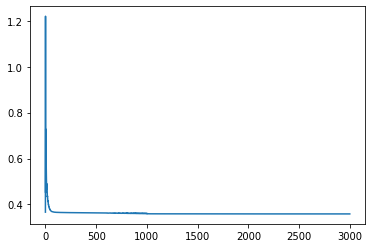

In [81]:
# training loop
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**22,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()

n_epochs = 1000
lr0=1e-2
lr_steps=3
losses = train(md, dl, torch_data, L, n_epochs=n_epochs, lr_steps=lr_steps, lr0=lr0)

plt.plot(losses)

In [82]:
# for smaller data
idx_full = np.concatenate([xx[:,:,:,None], yy[:,:,:,None], zz[:,:,:,None]], axis=-1)
idx_full_torch = torch.Tensor(idx_full).float()

splitted_idx = torch.split(idx_full_torch, 1)
res_list = []
for t in splitted_idx:
    res_list.append(md(t.to(device)).data.cpu().sigmoid().numpy().squeeze(-1))

res_full = np.concatenate(res_list, axis=0)

### Visualization 

In [83]:
def plot_selected_slices(selected_idx, res_full, data, mask, axis='z', idx_plot=1):
    res = res_full[selected_idx]

    #plt.suptitle(axis+' slice', fontsize=14)
    plt.subplot(3, 2, 2*idx_plot-1)
    plt.imshow(res[:, :], cmap='gray')
    plt.title('generated ' + axis + ' slice')

    

    data_sel = data[selected_idx]
    '''
    mask_sel = mask[selected_idx]
    new_mask = np.zeros((mask_sel.shape[0], mask_sel.shape[1], 3), dtype=int)
    new_mask[mask_sel] = np.array([254,0,0])
    masked_data = new_mask.copy()
    data_rgb = np.zeros((data_sel.shape[0],data_sel.shape[1],3),dtype=int)
    data_rgb[data_sel==1,:] = np.array([255,255,255])
    masked_data[new_mask[:,:,0] == 0] = data_rgb[new_mask[:,:,0] == 0]
    '''

    plt.subplot(3, 2, 2*idx_plot)
    plt.imshow(data_sel, cmap='gray')
    plt.title('real ' + axis + ' slice')

K: 4 , sigma: 2.0 , N basis fun: 15


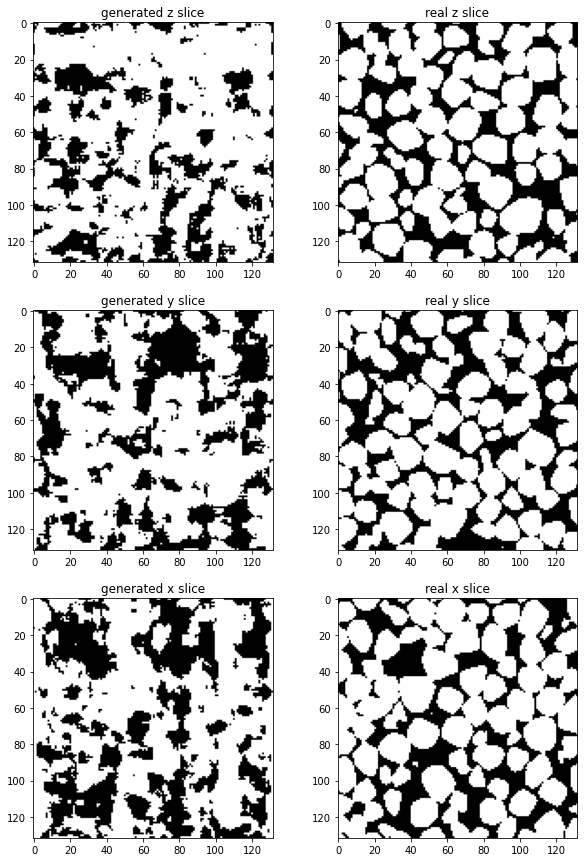

In [84]:
print("K:", k, ", sigma:", sigma, ", N basis fun:", num_freq)
sel_slice = 30
#res_sigm = torch.from_numpy(result_np).float().sigmoid().numpy()

sel = (slice(None), slice(None), sel_slice)
plt.figure(figsize=(10,15))
plot_selected_slices(sel, (res_full>0.5).transpose(1,0,2), data, mask, idx_plot=1)

sel = (slice(None), sel_slice, slice(None))
plot_selected_slices(sel, (res_full>0.5).transpose(1,0,2), data, mask, axis='y', idx_plot=2)

sel = (sel_slice, slice(None), slice(None))
plot_selected_slices(sel, (res_full>0.5).transpose(1,0,2), data, mask, axis='x', idx_plot=3)

In [107]:
porosity_on_train = 1- np.sum(data*mask) / np.sum(mask)
print(porosity_on_train)

0.3433604843799306


In [108]:
porosity_original = 1- np.sum(data) / np.prod(data.shape)
print(porosity_original)

0.3417269283746557


In [109]:
def porosity(data):
  return 1- np.sum(data) / np.prod(data.shape)

In [114]:
porosity(res_full>.55)

0.34139214110805016

In [86]:
np.save(data_path+'fourier_{}'.format(res_full.shape[0]), res_full)

In [87]:
np.save(data_path+'fourier_132', res_full)

K: 4 , sigma: 2.0 , N basis fun: 15


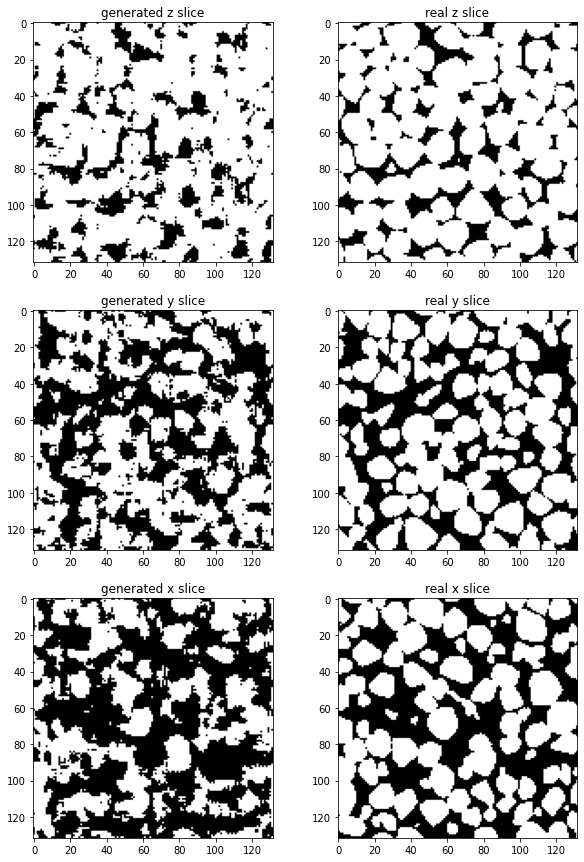

In [96]:
thresh = 0.65

print("K:", k, ", sigma:", sigma, ", N basis fun:", num_freq)
sel_slice = 0
#res_sigm = torch.from_numpy(result_np).float().sigmoid().numpy()

sel = (slice(None), slice(None), sel_slice)
plt.figure(figsize=(10,15))
plot_selected_slices(sel, res_full.transpose(1,0,2)>thresh, data, mask, idx_plot=1)

sel = (slice(None), sel_slice, slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2)>thresh, data, mask, axis='y', idx_plot=2)

sel = (sel_slice, slice(None), slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2)>thresh, data, mask, axis='x', idx_plot=3)

In [89]:
# print("K:", k, ", sigma:", sigma, ", N basis fun:", num_freq)
# sel_slice = 20
# #res_sigm = torch.from_numpy(result_np).float().sigmoid().numpy()

# sel = (slice(None), slice(None), sel_slice)
# plt.figure(figsize=(10,15))
# plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, idx_plot=1)

# sel = (slice(None), sel_slice, slice(None))
# plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='y', idx_plot=2)

# sel = (sel_slice, slice(None), slice(None))
# plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='x', idx_plot=3)

In [90]:
res_full.shape

(132, 132, 132)

In [91]:
np.save(data_path+'best_fourier_full_res', res_full)

In [ ]:
np.save(data_path+'fourier_full_res_dowscaled', res_full[::4,::4,::4])